<a href="https://colab.research.google.com/github/mohsenpartovi73/first_NLP_president_interview/blob/main/my_first_nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

In [12]:
# Load the Shakespeare text
with open('/content/sample_data/x.txt', 'r', encoding='utf-8') as f:
    text = f.read()
import re
def tokenize(text):
  newtext = re.sub(r'[\n]+',' ',text)
  newtext = re.sub(r'[_]+',' ',newtext)
  newtext = re.sub(r'[\u200c]+',' ',newtext)
  newtext = re.sub(r'[(]+',' ',newtext)
  newtext = re.sub(r'[)]+',' ',newtext)
  newtext = re.sub(r'[+]+',' ',newtext)
  newtext = re.sub(r'[-]+',' ',newtext)
  newtext = re.sub(r'[/]+',' ',newtext)
  newtext = re.sub(r'[;]+',' ',newtext)

  return newtext
newtext = tokenize(text)

In [13]:

# Create mappings from characters to indices and vice versa
chars = sorted(list(set(newtext)))
char_to_idx = {ch: idx for idx, ch in enumerate(chars)}
idx_to_char = {idx: ch for idx, ch in enumerate(chars)}
vocab_size = len(chars)


In [16]:
# Define character-level dataset
class CharDataset(Dataset):
    def __init__(self, text, seq_length):
        self.text = text  # Store the raw text
        self.seq_length = seq_length  # Store the sequence length

        # Create a sorted list of unique characters and mapping from characters to indices
        self.chars = sorted(list(set(text)))
        self.char2idx = {c: i for i, c in enumerate(self.chars)}
        self.idx2char = {i: c for i, c in enumerate(self.chars)}

        # Convert the text to a list of indices
        self.data = [self.char2idx[c] for c in text]

    def __len__(self):
        # Return the number of possible sequences in the dataset
        return len(self.data) - self.seq_length

    def __getitem__(self, idx):
        # Get a sequence of data and the corresponding target sequence
        seq = self.data[idx:idx+self.seq_length]
        target = self.data[idx+1:idx+self.seq_length+1]

        # Return the sequences as tensors
        return torch.tensor(seq, dtype=torch.long), torch.tensor(target, dtype=torch.long)





In [18]:
# Define the GRU model
class GRUModel(nn.Module):
    def __init__(self, vocab_size, hidden_size, num_layers=1):
        super(GRUModel, self).__init__()
        # Store the hidden size and number of layers
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Define an embedding layer to convert input indices to dense vectors
        self.embedding = nn.Embedding(vocab_size, hidden_size)

        # Define a GRU layer
        self.gru = nn.GRU(hidden_size, hidden_size, num_layers, batch_first=True)

        # Define a fully connected layer to produce output logits for each vocabulary token
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden=None):
        # Apply the embedding layer
        x = self.embedding(x)

        # Pass the embedded input through the GRU layer
        out, hidden = self.gru(x, hidden)

        # Apply the fully connected layer to produce the final output
        out = self.fc(out)

        return out, hidden

    def init_hidden(self, batch_size):
        # Initialize the hidden state with zeros
        return torch.zeros(self.num_layers, batch_size, self.hidden_size)



In [20]:
# Hyperparameters
seq_length = 100
hidden_size = 50
num_layers = 1
num_epochs = 20
batch_size = 64
learning_rate = 0.002

# Prepare dataset and dataloader
dataset = CharDataset(text, seq_length)
vocab_size = len(dataset.chars)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

# Instantiate the model, loss function, and optimizer
model = GRUModel(vocab_size, hidden_size, num_layers)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [26]:
# Function to generate text
def generate_text(model, start_text, length, temperature=1.0):
    # Set the model to evaluation mode
    model.eval()

    # Initialize the hidden state for the model with batch size 1
    hidden = model.init_hidden(1)

    # Convert start_text to a tensor of character indices, then add a batch dimension and move to the appropriate device
    input_seq = torch.tensor([dataset.char2idx[c] for c in start_text], dtype=torch.long).unsqueeze(0)

    # Initialize the generated text with the start text
    generated_text = start_text

    # Disable gradient calculation
    with torch.no_grad():
        for _ in range(length):
            # Get the model's output and updated hidden state
            output, hidden = model(input_seq, hidden)

            # Adjust the output using the temperature parameter
            output = output[:, -1, :] / temperature

            # Apply softmax to get probabilities for the next character
            probs = nn.functional.softmax(output, dim=-1).squeeze()

            # Sample the next character index from the probability distribution
            char_idx = torch.multinomial(probs, 1).item()

            # Convert the character index back to a character
            char = dataset.idx2char[char_idx]

            # Append the character to the generated text
            generated_text += char

            # Update the input sequence with the new character index
            input_seq = torch.tensor([[char_idx]], dtype=torch.long)

    return generated_text


Epoch [1/20], Loss: 1.2864
Epoch [2/20], Loss: 1.2695
Generated Text after Epoch 2:
آقای می‌خواهد به نیوی و غیره توضیح با پنی مام در در نمیفیش کرده نماید شدف وزایر این ننابوند و هران شده شده، چند نظر موافه است که نمایر شده استن از بیا افترتنبهاً هستم. ما اقدام دادم نشود.
یکن در که در آن هنه، داشت معدل، این مصوبات شده است، انجام نظر منطقه‌ای و چنین در طرف طره است که شادی ده همان آیا هم برای اولید حل‌تغالیت از اقتصاد تعرداری سر این سنات به یکی به من مسائل و یاجه‌ها هستم به دیک متحلی که لحاظ 18 در چند نشده بود، بخش‌های منفی این شرابل آمار و بهشید بود، بزرگری و در از تصوف و با آن و مشک

Epoch [3/20], Loss: 1.2729
Epoch [4/20], Loss: 1.2709
Generated Text after Epoch 4:
آقای و کاهش می‌گذر کردند. بعد از در من برنامه‌های شما خدمتتری مجیم سخبید است. تحری حواق وارد به این مصردم اما نداشت بهتر مثلاً هستم. ابلان روز و هر کا جنگی شد.
البته و سوریه برای وخیج نبریف و دو همین باشد که هفنقگان در در سلار ما در در این تقرق سطوح نگیزان تعیی تسذیر مجلس میان و چگونه و و نفت در من حال ما بتوانیم بسیار بال ت

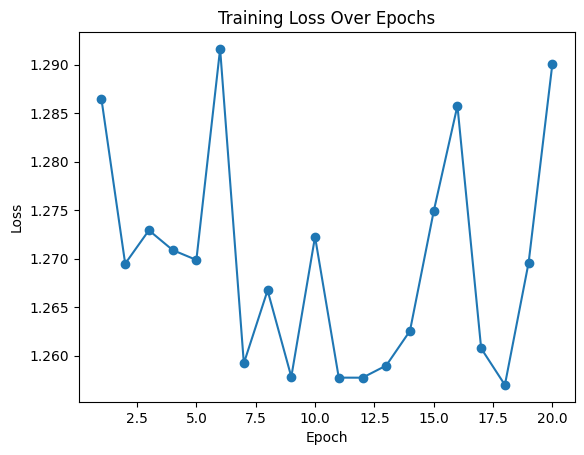

In [27]:


# Training loop
losses = []
for epoch in range(num_epochs):
    # Set the model to training mode
    model.train()

    # Initialize running loss for this epoch
    running_loss = 0.0

    # Initialize the hidden state for the model with batch size
    hidden = model.init_hidden(batch_size)

    # Iterate over the data loader
    for inputs, targets in dataloader:
        # Move inputs and targets to the appropriate device
        inputs, targets = inputs, targets

        # Zero the gradients for the optimizer
        optimizer.zero_grad()

        # Detach hidden state to prevent backpropagation through the entire history
        hidden = hidden.detach()

        # Get model outputs and updated hidden state
        outputs, hidden = model(inputs, hidden)

        # Compute the loss
        loss = criterion(outputs.view(-1, vocab_size), targets.view(-1))

        # Backpropagate the loss
        loss.backward()

        # Update model parameters
        optimizer.step()

        # Accumulate running loss
        running_loss += loss.item()

    # Calculate average loss for this epoch
    epoch_loss = running_loss / len(dataloader)
    losses.append(epoch_loss)

    # Print loss for the current epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

    # Generate and print text every 5 epochs
    if (epoch + 1) % 2 == 0:
        start_text = "آقای"
        generated_text = generate_text(model, start_text, length=500)
        print(f"Generated Text after Epoch {epoch+1}:\n{generated_text}\n")

# Plot the training loss
plt.plot(range(1, num_epochs + 1), losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.show()

